# 合成資料品質檢查

In [83]:
import numpy as np
import pandas as pd
from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

from sdmetrics.single_column import (
    KSComplement,
    RangeCoverage,
    MissingValueSimilarity,
    StatisticSimilarity,
)

# 產出真實資料與合成資料品質比較報告

In [96]:
## inputs
real_data = pd.read_csv("input/data.csv")  ## 真實資料路徑
synthetic_data = pd.read_csv("output/syn_data.csv") ## 合成資料路徑

print(real_data.columns)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
metadata = metadata.to_dict()
 
report = QualityReport()
report.generate(real_data, synthetic_data, metadata)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [85]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Score,Error
0,MSSubClass,KSComplement,0.520274,None
1,MSZoning,TVComplement,0.944623,None
2,LotFrontage,KSComplement,0.861596,None
3,LotArea,KSComplement,0.843596,None
4,Street,TVComplement,0.994281,None
...,...,...,...,...
74,MoSold,KSComplement,0.928870,None
75,YrSold,TVComplement,0.899966,None
76,SaleType,TVComplement,0.970445,None
77,SaleCondition,TVComplement,0.946473,None


In [86]:
fig = report.get_visualization(property_name='Column Shapes')
fig.show()

In [97]:
def compare_numeric_columns(real_df, syn_df, column, bins=30):
    real_vals = real_df[column].dropna()
    syn_vals = syn_df[column].dropna()

    # 計算 KSComplement
    stat, _ = ks_2samp(real_vals, syn_vals)
    ks_score = 1 - stat

    plt.figure(figsize=(8, 4))
    plt.hist(real_vals, bins=bins, alpha=0.5, label='Real', density=True)
    plt.hist(syn_vals, bins=bins, alpha=0.5, label='Synthetic', density=True)
    plt.title(f"{column} Distribution\nKSComplement: {ks_score:.4f}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [98]:
def compare_categorical_columns(real_df, syn_df, column):
    real_counts = pd.Series(real_df[column]).value_counts(normalize=True)
    syn_counts = pd.Series(syn_df[column]).value_counts(normalize=True)
    categories = sorted(set(real_counts.index).union(syn_counts.index))

    real_vals = [real_counts.get(cat, 0) for cat in categories]
    syn_vals = [syn_counts.get(cat, 0) for cat in categories]

    # 計算 TVComplement
    tv = sum(abs(r - s) for r, s in zip(real_vals, syn_vals)) / 2
    tv_score = 1 - tv

    x = np.arange(len(categories))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, real_vals, width, label='Real')
    plt.bar(x + width/2, syn_vals, width, label='Synthetic')
    plt.xticks(x, categories, rotation=45)
    plt.title(f"{column} Distribution\nTVComplement: {tv_score:.4f}")
    plt.ylabel("Proportion")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 視覺化比較真實 v.s. 合成資料的特定數值欄位

In [99]:
from sdmetrics.single_column import KSComplement

KSComplement.compute(
    real_data=real_data['LotFrontage'],
    synthetic_data=synthetic_data['LotFrontage']
)

np.float64(0.9256172004352758)

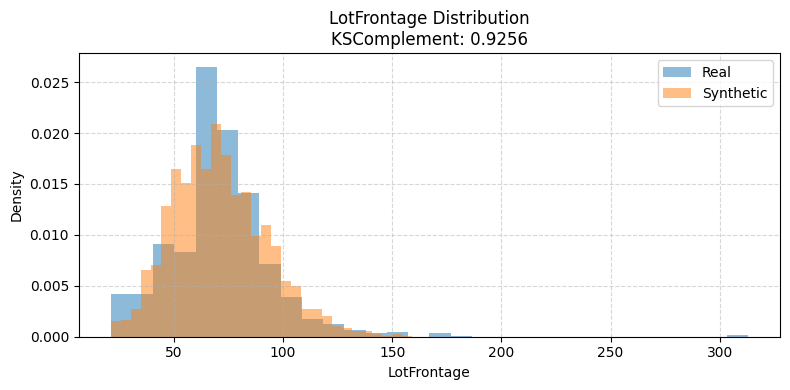

In [100]:
compare_numeric_columns(real_data, synthetic_data, column="LotFrontage")

### 視覺化比較真實 v.s. 合成資料的特定類別欄位

In [101]:
from sdmetrics.single_column import TVComplement
TVComplement.compute(
    real_data=real_data['MSZoning'],
    synthetic_data=synthetic_data['MSZoning']
)

0.9962990867579908

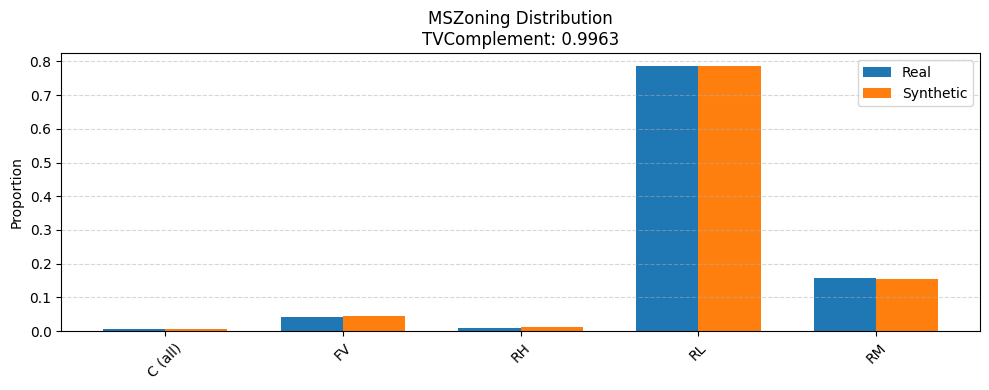

In [102]:
compare_categorical_columns(real_data, synthetic_data, column="MSZoning")

In [103]:
syndata_eval_df = report.get_details('Column Shapes')
# 整理欄位的平均分數（越低越值得關注）
low_quality_columns = (
    syndata_eval_df
    .groupby("Column")["Score"]
    .mean()
    .sort_values()
    .reset_index()
)

print("💔 合成品質最差的前 10 欄位：")
print(low_quality_columns.head(10))


💔 合成品質最差的前 10 欄位：
         Column     Score
0       MiscVal  0.052247
1    BsmtFinSF2  0.111468
2      2ndFlrSF  0.451689
3   OpenPorchSF  0.552559
4   ScreenPorch  0.555623
5    MasVnrArea  0.572402
6    MSSubClass  0.579274
7    GarageArea  0.625806
8    BsmtFinSF1  0.655450
9  LowQualFinSF  0.685267


In [104]:
threshold = 0.7
low_scores = syndata_eval_df[syndata_eval_df["Score"] < threshold]

print(f"⚠️ 分數低於 {threshold} 的指標：")
display(low_scores.sort_values(by="Score"))

⚠️ 分數低於 0.7 的指標：


,Column,Metric,Score
73,MiscVal,KSComplement,0.052247
35,BsmtFinSF2,KSComplement,0.111468
43,2ndFlrSF,KSComplement,0.451689
66,OpenPorchSF,KSComplement,0.552559
68,ScreenPorch,KSComplement,0.555623
25,MasVnrArea,KSComplement,0.572402
0,MSSubClass,KSComplement,0.579274
61,GarageArea,KSComplement,0.625806
33,BsmtFinSF1,KSComplement,0.655450
44,LowQualFinSF,KSComplement,0.685267


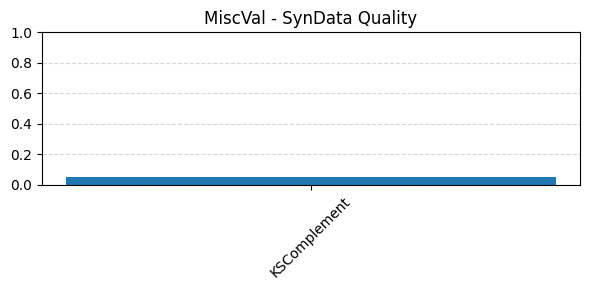

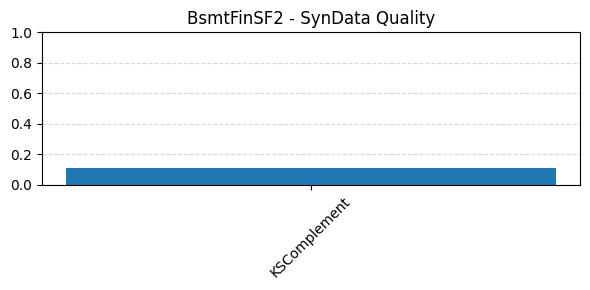

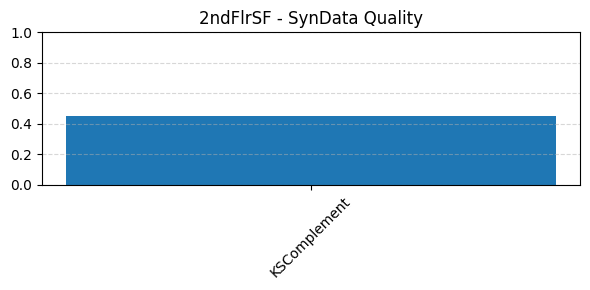

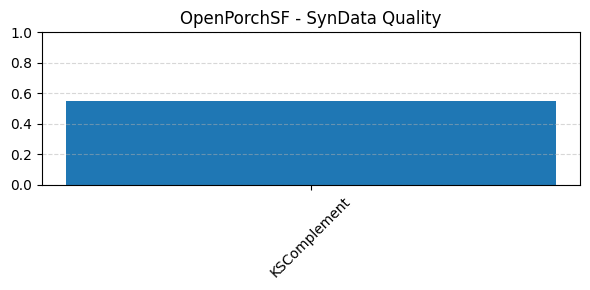

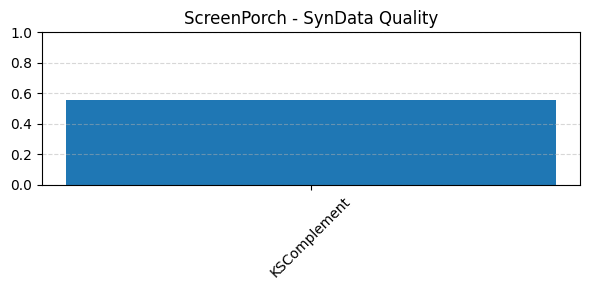

In [105]:
import matplotlib.pyplot as plt

def plot_lowest_score_columns(results_df, top_n=5):
    low_avg = (
        results_df.groupby("Column")["Score"]
        .mean()
        .sort_values()
        .head(top_n)
    )

    for col in low_avg.index:
        col_scores = results_df[results_df["Column"] == col]
        plt.figure(figsize=(6, 3))
        plt.bar(col_scores["Metric"], col_scores["Score"])
        plt.title(f"{col} - SynData Quality")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# 使用範例
plot_lowest_score_columns(syndata_eval_df, top_n=5)